## 2016 SEG Machine Learning Entry
##### Adam McCarthy
## Introduction

Based on: https://github.com/seg/2016-ml-contest. Co-ordinated by Matt Hall
wFollowing Brendon Hall's tutorial in the leading edge.

A question to consider at the start of a data science exercise is "can this problem be solved by an experienced human?". From a geoscience background, the initial hunch is no. This is also reflected in the moderate scores, no team has over 65% yet. 

We want to define a function y = h(X) 
Where y is originaly based on y = h(U)
Where: h(U) is a geological interpretation of core data and will not be reproducible in this experiment. It is not assured that y can be predicted based only on these well logs.

This evaluation investigated this idea and consider what could be done to allow for a higher score. It followed:

1. Consider if the problem can be answered.
2. Exploratory data analysis.
3. Test a simple model.
4. Select base models based on testing models with different parameters.
5. Engineer extra features and optimize.

###### Mistakes made along the way and/or lessons learned!
1. Trained model on cross validated data then refit best parameters on all data, appears to have led to overfitting, specifically on facies 9. = 0.44, 0.54 with facies 9 converted to 8 manually.
2. Tested for why facies 9 seemed to dominate, appears to be overfitting F9 with different models and different approaches. OneVsOne may be key to stopping F9 dominating the prediction. Removed F9 entirely to try to create a base model before trying feature engineering. Led to a 0.552 test. This seems a good attempt before adding more sophisticated feature engineering, trainnig score is only 0.45.
3. Feature engineering. Still have not cross-referenced the same method with OneVsOne because XGB boost gives errors that have not been fixed when attempting to use in OneVsOne. Additionaly changed the script to use the classifier from parameter testing. It seems GridSearchCV will refit the classifier on all data after identifying best parameters with an inner loop cross validation. This classifier is taken out of GridSearchCV and used directly for prediction. This still only resulted in 0.545. So no improvement.
4. At this time many models have been explored, a number of teams are using LeaveGroupOut as a CV tool instead of KFold or Stratified KFold. After a long investigation there is a way to include this into a GridSearchCV process. This was run without F9 and missing wells and then with F9 and all wells. Still a lot of green, bafflestone while including F9. 
Scores are:
Using the same feature engineering. 
0.561 for an update to OneVsOne with Kfold cross validation stratergy. Not including F9, and wells CHC or F9 recruit
0.549 for a OneVsOne with LeaveGroupsOut (wells) cross validation stratergy. Not including F9, and wells CHC or F9 recruit.
0.441 for a OneVsOne with LeaveGroupsOut (wells) cross validation stratergy. Not including F9 recruit.
So bit of a suprise that didn´t seem to help. 
V8 attempted to add some minor feature engineering additions. For example running Tfidf vectorization of the text information in Formation name. This led to 0.559.

Drafts have been made for a machine learning prediction for PE, and other categories and for feature selection based on random forest. However given the high number of quickly changing results after prediction the result looks like it needs to be smoothed. The expectation is this will improve with time-series features like lag and averaging over a window.

Rolling averages, mins and maxes are created and put through a run


In [ ]:

#### Conclusions
The results suggest that there is significant overlap in the wireline well log responses for a number of facies. That even with feature engineering it can be difficult to differentiate. It is beyond the scope of this submission to discuss the geological and petrophysical reasons for this. One key example is non-marine coarse siltstone vs. non-marine fine siltstone, this produces the most errors of all models tested. Even in core these two can be challenging to interpret. Perhaps gouping into one non-marine siltstone would be more suitable for a modelling exercise.

The learning curves and other QC plots do not seem to suggest that obtaining more data will neccisarily make this better as they all flatten out early. The main problem here is recall. Either the question should be reconfigured to ask for rock property groups that can be defined by a petrophysicist or a greater variety of well logs should be used. E.g. spectral gamma ray.

Once starting to fit models facies 9 (Bafflestones) tended to dominate the responses and overprint other carbonate facies that appear to be the right choice when submitting testing. By deleting F9 entirely this could be proven in the test scores. At this stage OneVsOne, OneVsRest and a standard model were fit all using a boosted tree model. When including F9 they would all demonstrate this issue and result in a large number of F9 facies and lower scores.

>"The splitting of data into training and validation sets “must” be done according to labels. In case of any kind of classification problem, use stratified splitting. In python, you can do this using scikit-learn very easily." <cite>Abhishek Thakur<cite>.  

Yet after exhaustive testing it was only using Leave Groups Out and leaving 2 wells out at a time that the models started to perform well or with K-Fold without stratification. When looking at the plot showing the distribution of facies it can be seen that the distribution is mixed across wells so perhaps this method is succesfully presenting only models that can be fitted to very different outputs of wells and therefore perform better against the test data.

The CRAWFORD well also has an interpolation gap (3025-3040 in the well logs where they go diagonally from one value to the next. This will not be easy to predict as the values should not correspond. CHURCHMAN BIBLE also has a gap in the well logs that has been interpolated. However the prediction does a decent job at having an attempt, it will have low accuracy but it is impressive to see that it can make a prediction in an interval which appears to have false log values. This may be more of a reflection of overfitting than something that will succesfully generalize. 

A score around 90-95% may be needed to give confidence to be implemented in a producing field. The conclusions for this evaluation is that the experimental design needs to changed to be able to achieve this. This competition and the original paper has been a fantastic way to start a discussion within the geoscience community around machine learning, the lower scores appear to be a limitation of this specific challenge rather than the machine learning methodology.

##### Initializing

In [3]:
#     Initializing

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import seaborn as sns

#Enable inline plotting
%matplotlib inline

print ("This has been run using:")
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

## Set colour template
sns.set(style="ticks")    ## Set style to white background and ticks
sns.set_context("paper")   ## Set size of labels

#     Load file
try:
    print("Loading dataset...")
    CSV_Dataset = r"facies_vectors.csv"
    Dataset = pd.read_csv(CSV_Dataset)
except:
    print ("An error has occured")
    print ("Please ensure that you have downloaded the dataset and")
    print ("entered the file location and file path for your machine")
finally:
    print ("Expected input is the file facies_vectors.csv")

Dataset.head()

## Remove Recruit F9
Dataset = Dataset[Dataset["Well Name"] != "Recruit F9"]
Dataset = Dataset[Dataset["Well Name"] != "CROSS H CATTLE"]
Dataset = Dataset[Dataset["Facies"] != 9]

This has been run using:
Python version 3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version 0.19.1
Matplotlib version 1.5.3
Loading dataset...
Expected input is the file facies_vectors.csv


## Step 2: Checking the data and view facies

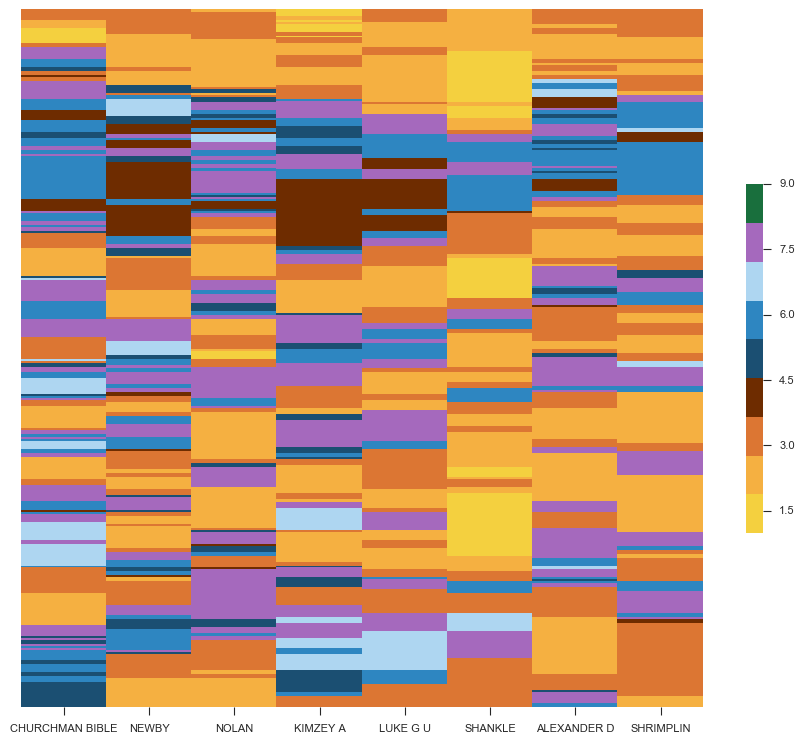

In [144]:
#### Make a new array  that consists of the facies organised in columns for each well
Facies_Plot = Dataset.iloc[:,0]
Well = Dataset.iloc[:,2]

Facies_Plot = pd.concat([Facies_Plot, Well], axis=1)
grouped = Facies_Plot.groupby('Well Name')
Facies_Plot = Facies_Plot.rename(columns = {"Well Name":"Well_Name"}) # To be able to use the header in the .unique method
List = Facies_Plot.Well_Name.unique()

u = np.arange(501)  #make a dummy key based on the legth of the longest well - Should be automated.
b = pd.DataFrame()
b["key"]=u

for i in List:
    a = grouped.get_group(i)
    a = a.rename(columns = {"Facies":i})
    a = a.drop("Well Name", 1)
    [c, d] = a.shape
    e = np.arange(c)
    a["key"]=e
    #b = pd.concat([a, b], axis=1)
    b = pd.merge(a, b, on='key')
Facies_Plot = b
Facies_Plot = Facies_Plot.drop("key", 1)

cmap_facies = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
from matplotlib.colors import ListedColormap
cmap_list = ListedColormap(cmap_facies)

## Plot all facies to give a visual impression of the distribution of facies
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(Facies_Plot, yticklabels=False, cmap=cmap_list, linewidths=0, vmin=1, vmax=9, ax=ax, cbar_kws={"shrink": .5})

###### Make new classes, X, y and dataframe for visualisations

In [175]:
### Create new categories ####

ytemp= Dataset.iloc[:,0]

def new_categories(y):
    
    def create_category(facies_names, y):
        a = 1
        for i in facies_names:
            y = y.replace(to_replace=a,value=i)
            a+=1
        return y

    ##Relable numerics with String label
    ytemp_1=y
    facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

    ytemp_1=create_category(facies_names, ytemp_1)

    ## Make a new column of depositional environments
    ytemp_2=ytemp    
    ytemp_2 = ytemp_2.rename(columns = {"Facies":"Dep Environment"})
    facies_names = ['Clastic Non-marine', 'Clastic Non-marine', 'Clastic Non-marine', 'Clastic Non-marine', 'Clastic Marine', 'Carb Platform', 'Carb Platform', 'Carb Platform', 'Carb Platform']

    ytemp_2=create_category(facies_names, ytemp_2)

    ## Make a new column of clastic vs. carbonate
    ytemp_3=ytemp
    ytemp_3.rename(columns={"Facies":"Lithology"}, inplace=True)
    facies_names = ['Clastic', 'Clastic', 'Clastic', 'Clastic', 'Clastic', 'Carb', 'Carb', 'Carb', 'Carb']

    ytemp_3=create_category(facies_names, ytemp_3)

    ## Make a new column of non-marine vs. marine
    ytemp_4=ytemp
    ytemp_4.rename(columns={"Facies":"Marine vs Non-marine"}, inplace=True)
    facies_names = ['Non-marine', 'Non-marine', 'Non-marine', 'Marine', 'Marine', 'Marine', 'Marine', 'Marine', 'Marine']

    ytemp_4=create_category(facies_names, ytemp_4)

    ## Merge the results into a new table
    y = pd.concat([ytemp_1, ytemp_2, ytemp_3, ytemp_4], axis=1)
    y.rename(columns={0:"Dep Environment"}, inplace=True)
    y.rename(columns={1:"Lithology"}, inplace=True)
    y.rename(columns={2:"M vs NM"}, inplace=True)
    new_classes = y
    
    return new_classes

new_classes = new_categories(ytemp)


X, y, y_one_column = prepare_X_Y(Dataset)

## Merge together new class labels, y results as one hot vecotr and X
df_full = pd.concat([new_classes, y, X], axis=1)
df = pd.concat([new_classes, X], axis=1)

            Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3964.000000  3964.000000  3964.000000  3964.000000  3964.000000   
mean      4.293391  2900.946393    65.925832     0.662245     4.560130   
std       2.328107   132.814458    30.012673     0.248731     5.275988   
min       1.000000  2573.500000    10.149000    -0.025949   -21.832000   
25%       2.000000  2816.000000    47.716750     0.502000     1.800000   
50%       3.000000  2926.500000    66.009500     0.639000     4.464500   
75%       6.000000  3000.000000    80.060750     0.823000     7.647250   
max       8.000000  3138.000000   361.150000     1.800000    19.312000   

             PHIND           PE         NM_M       RELPOS  
count  3964.000000  3071.000000  3964.000000  3964.000000  
mean     13.219628     3.642657     1.495964     0.524566  
std       7.237590     0.819939     0.500047     0.288699  
min       0.550000     0.200000     1.000000     0.000000  
25%       8.450000     3.100000  

## Plots to assess distribution of parameters

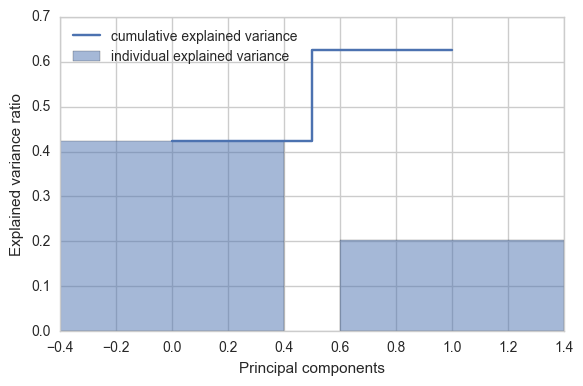

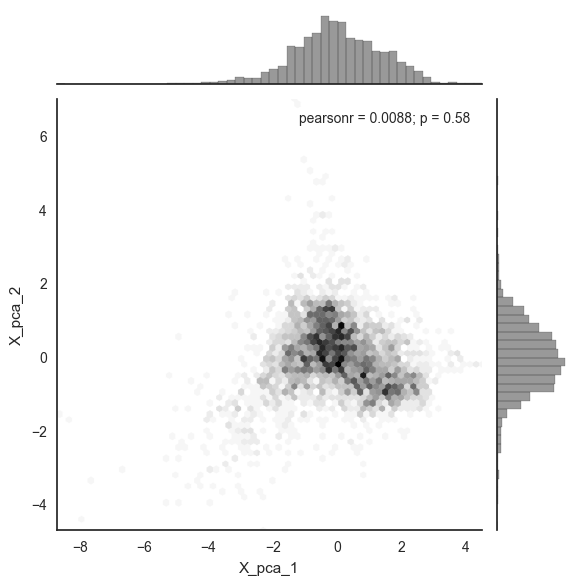

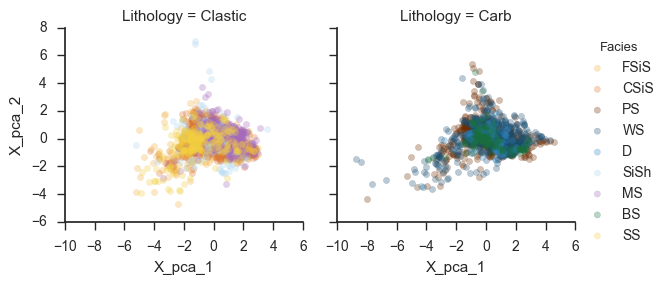

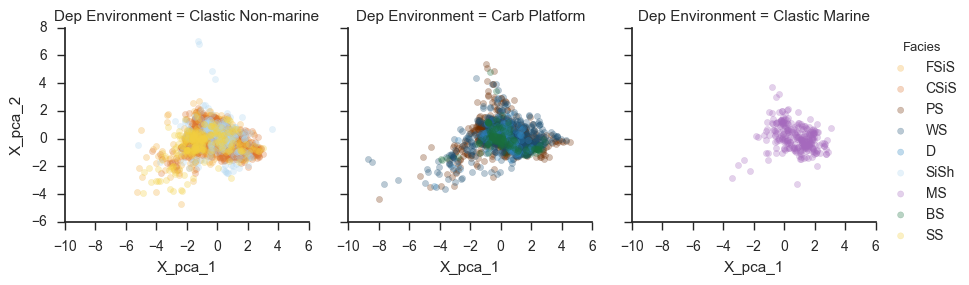

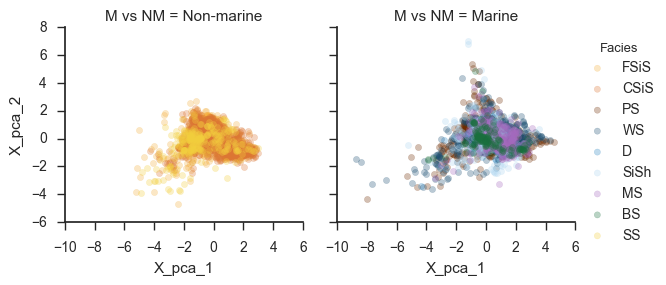

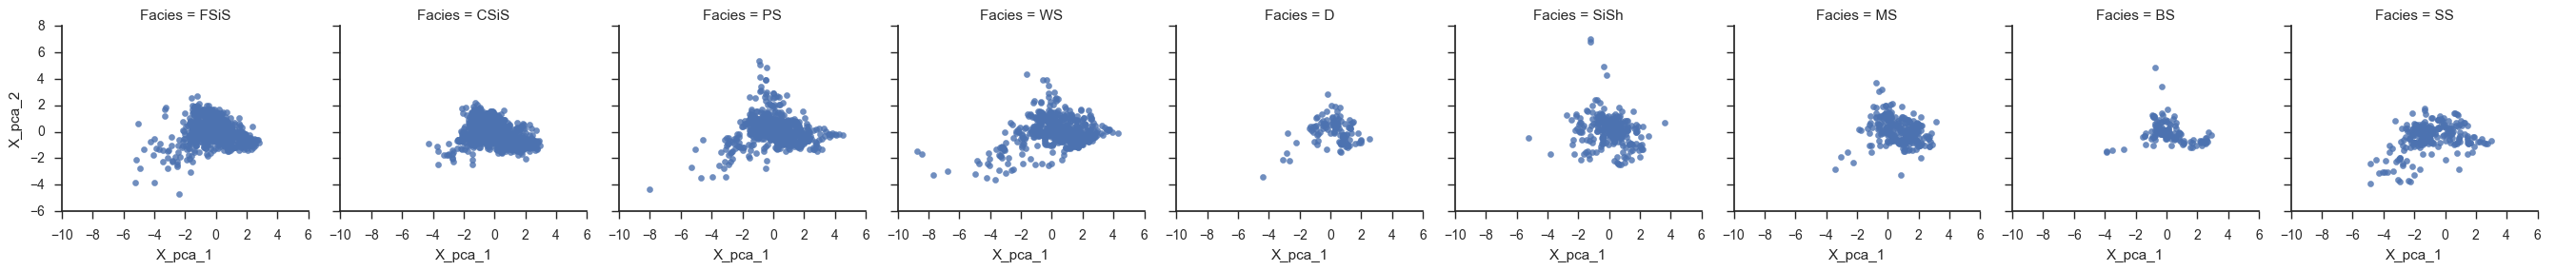

In [47]:
### Set some colour parameters.
cmap_facies = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
cmap_m_nm = ["sage", "royalblue"]
cmap_clas_carb = ["gold", "slategrey"]

##### Principal Component Analysis #####

# Drop well name and binary features
drop = ["Well Name", "NM_M", "Depth", "Formation"]
X_temp = X
X_temp = X.drop(drop, 1)

# Data should be preprocessed using mean normalisation before input to principal component analysis. 
# After mean normalization each parameter should have zero mean. (mean=0 and variance=1).
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
#X_Scaler = StandardScaler()
X_Scaler = RobustScaler()
X_Scaled = X_Scaler.fit_transform(X_temp)

# Project onto the linear subspace spanned by k number of vectors.
K = 2 # K is called number of n_components in Sci Kit learn.
from sklearn.decomposition import PCA, IncrementalPCA
ipca = IncrementalPCA(n_components=K, batch_size=10)
X_ipca_K2 = ipca.fit_transform(X_Scaled)

# Choose K by looking to retain 99% (0.01) of variance. K should be the smallest value that will give a 99% variance.
# There can be some variations for example 95% (0.05).
cum_var_exp = np.cumsum(ipca.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range((ipca.n_components_)), ipca.explained_variance_ratio_, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(ipca.n_components_), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    
            ####### Plots ########
    
## Make a data frame using the 2 dimensional result from principal component analysis
df_ipca = pd.DataFrame(X_ipca_K2, columns=["X_pca_1", "X_pca_2"])
df_ipca = df = pd.concat([new_classes, df_ipca], axis=1)
with sns.axes_style("white"):
    sns.jointplot(x="X_pca_1", y="X_pca_2", data=df_ipca, kind="hex", color="k");
sns.set(style="ticks")

facies_colors = ['#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D', '#F4D03F']
cmap=facies_colors
pal_facies=sns.color_palette(cmap)

def pca_plot(List):
    for i in List:
        Lithology_pca = sns.FacetGrid(df_ipca, col=i, palette=pal_facies, hue="Facies")
        Lithology_pca.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.3)
        Lithology_pca.add_legend();

### Plot facies split against different categories ###
List = ["Lithology", "Dep Environment", "M vs NM"]
pca_plot(List)

### Plot all facies ###
Facies = sns.FacetGrid(df_ipca, col="Facies", palette=pal_facies)
Facies.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.8)
Facies.add_legend();

## Set all functions - Reproducibility and result

In [11]:

##############################################################
###### Define a set of functions to run the evaluation #######
##############################################################

def Start_up():

    print ("This has been run using:")
    print('Python version ' + sys.version)
    print('Pandas version ' + pd.__version__)
    print('Matplotlib version ' + matplotlib.__version__)

    ## Set colour template
    sns.set(style="ticks")    ## Set style to white background and ticks
    sns.set_context("paper")   ## Set size of labels

    try:
        print("Loading dataset...")
        CSV_Dataset = r"facies_vectors.csv"
        Dataset = pd.read_csv(CSV_Dataset)
    except:
        print ("An error has occured")
        print ("Please ensure that you have downloaded the dataset and")
        print ("entered the file location and file path for your machine")
    finally:
        print ("Expected input is the file facies_vectors.csv")

    return Dataset

#######################################################
################### Prepare X and y ###################
#######################################################
    
def prepare_X_Y(Dataset):
    ## Remove Recruit F9
    
    ##########################################################
    ####### Impute missing values with mean ##################
    ##########################################################
    
    ## Replace all missing values with the mean values
    Dataset = Dataset.fillna(Dataset.mean())
    
    ##########################################################
    ####### Remove wells or facies deemed distracting ########
    #########################################################
    
    well_list_remove = ["Recruit F9", "CROSS H CATTLE", "CHURCHMAN BIBLE"]
    
    for i in well_list_remove:
        Dataset = Dataset[Dataset["Well Name"] != i]
        
    Dataset = Dataset[Dataset["Facies"] != 9]
    
    def Average(df_in):
        df_d = df_in

        list_to_roll = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']
        window_size = [5,10,15]
        for w in window_size:
                for val in list_to_roll:
                        df_d[val+'_rollingmean_'+str(w)]=df_d.groupby("Well Name")[val].apply(
                            lambda x:x.rolling(window=w,center=True).mean())
                        df_d[val+'_rollingmax_'+str(w)]=df_d.groupby("Well Name")[val].apply(
                            lambda x:x.rolling(window=w,center=True).max())
                        df_d[val+'_rollingmin_'+str(w)]=df_d.groupby("Well Name")[val].apply(
                            lambda x:x.rolling(window=w,center=True).min())
                        df_d[val+'_rollingstd_'+str(w)]=df_d.groupby("Well Name")[val].apply(
                            lambda x:x.rolling(window=w,center=True).std())

        df_d = df_d.groupby(["Well Name"], as_index=False).apply(lambda group: group.bfill())
        df_d = df_d.groupby(["Well Name"], as_index=False).apply(lambda group: group.ffill())
        df_d = df_d.fillna(df_d.mean())

        return df_d

    Dataset = Average(Dataset)
    
    ###########################################################
    ########################## Make y #########################
    ###########################################################
    
    ytemp = Dataset.iloc[:,0] #Note 0 index is used in python for the first position. 
    #print (("m={0}").format(ytemp.shape))
        
    ## Keep the original version where all classifiers are stored in one columnn
    y_one_column = ytemp

    ####################################################################################
    ########## Make one hot vector version of y in case using OneVsRest ################
    ####################################################################################
    
    ## One hot vector for each valye of y. In case this is to be used as input for OneVsRest
    ## Get all the elements of y
    ySet = set(ytemp)
    Yn = len(ySet)
    #print (("K={0}").format(Yn))
    
    # Each classifier should have a sperate column and be measured only in ones and zeros
    one_hot_y = ytemp
    y = pd.get_dummies(one_hot_y)
    y = y.rename(columns={1: "NM Coarse Sandstone", 2: "NM Coarse Siltstone", 3: "NM Fine Siltstone", 4:"Marine Siltstone", 5:"Mud Stone", 6:"Wacke Stone", 7:"Dolomite", 8:"Packe Stone", 9:"Baffle Stone"})
    
    [Dm , Dn] = Dataset.shape
    X = Dataset.iloc[:,1:Dn]  #where Dn is the number of columns in the original dataset
    Dataset_out = Dataset
    ## X, y (One hot vector version), y (flat including intergers from 1-9).
    
    ####################################################################################
    ############### Make new categories based on grouping facies #######################
    ####################################################################################
    
    def new_categories(y):
    
        def create_category(facies_names, y):
            a = 1
            for i in facies_names:
                y = y.replace(to_replace=a,value=i)
                a+=1
            return y

        ##Relable numerics with String label
        ytemp_1=y
        facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

        ytemp_1=create_category(facies_names, ytemp_1)

        ## Make a new column of depositional environments
        ytemp_2=ytemp    
        ytemp_2 = ytemp_2.rename(columns = {"Facies":"Dep Environment"})
        facies_names = ['Clastic Non-marine', 'Clastic Non-marine', 'Clastic Non-marine', 'Clastic Non-marine', 'Clastic Marine', 'Carb Platform', 'Carb Platform', 'Carb Platform', 'Carb Platform']

        ytemp_2=create_category(facies_names, ytemp_2)

        ## Make a new column of clastic vs. carbonate
        ytemp_3=ytemp
        ytemp_3.rename(columns={"Facies":"Lithology"}, inplace=True)
        facies_names = ['Clastic', 'Clastic', 'Clastic', 'Clastic', 'Clastic', 'Carb', 'Carb', 'Carb', 'Carb']

        ytemp_3=create_category(facies_names, ytemp_3)

        ## Make a new column of non-marine vs. marine
        ytemp_4=ytemp
        ytemp_4.rename(columns={"Facies":"Marine vs Non-marine"}, inplace=True)
        facies_names = ['Non-marine', 'Non-marine', 'Non-marine', 'Marine', 'Marine', 'Marine', 'Marine', 'Marine', 'Marine']

        ytemp_4=create_category(facies_names, ytemp_4)

        ## Merge the results into a new table
        y = pd.concat([ytemp_1, ytemp_2, ytemp_3, ytemp_4], axis=1)
        y.rename(columns={0:"Dep Environment"}, inplace=True)
        y.rename(columns={1:"Lithology"}, inplace=True)
        y.rename(columns={2:"M vs NM"}, inplace=True)
        new_classes = y

        return new_classes

    new_classes = new_categories(y_one_column)
    
    return X, y, y_one_column, new_classes

#############      ###################


#####################################################################
####################### Feature Engineering #########################
#####################################################################


def prepare_X(X):
    
    ## Merge together new class labels, y results as one hot vecotr and X
    #df_full = pd.concat([y, X], axis=1)
    #df = pd.concat([X], axis=1)
    
    ####################################################################
    ################# Time Series Features #############################
    ####################################################################
    print("start", X.shape)
    Well_List = X['Well Name'].unique()
    print ("Wells used:", Well_List)
    
    ## Feature engineering. All features have shown importance in PCA
    ## Take advantage of this by creating new features based on the relationships of key featuers.
    ## Make relationships between key features
    
    
    ###################################################################
    ###### Features based on the relationships with each other ########
    ###################################################################
    
    X["DeltaPHI_PHIND"]=(X["DeltaPHI"]*X["PHIND"])
    X["GR_PE"]=(X["GR"]*X["PE"])
    X["PHIND_PE"]=(X["PHIND"]*X["PE"])
    X["DeltaPHI_PE"]=(X["DeltaPHI"]*X["PE"])
    X["ILD_log10_PE"]=(X["ILD_log10"]*X["PE"])
    X["DeltaPHI_PHIND2"]=(X["DeltaPHI"]/X["PHIND"])
    X["GR_ILD_log10"]=(X["GR"]*X["ILD_log10"])
    X["GR_PHIND"]=(X["GR"]*X["PHIND"])
    X["GR_PHIND2"]=(X["GR"]/X["PHIND"])
    X["GR_DeltaPHI"]=(X["GR"]*X["DeltaPHI"])
    X["ILD_log10_PHIND"]=(X["ILD_log10"]*X["PHIND"])
    X["ILD_log10_DeltaPHI"]=(X["ILD_log10"]*X["DeltaPHI"])
    X["PHIND_PE2"]=(X["PHIND"]/X["PE"])
    X["DeltaPHI_PE2"]=(X["DeltaPHI"]/X["PE"])
    
    #### N_MN is a powerfull feature, however it could also be misleading ####
    #### It is an interpreted feature not a raw log                       ####
    #### Keep seperate in case it needs to be blocked out                 ####
    #X["M_PE"]=(X["NM_M"]*X["PE"])
    #X["M_PE2"]=(X["NM_M"]/X["PE"])
    #X["M_PHIND"]=(X["NM_M"]*X["PHIND"])
    #X["M_PHIND2"]=(X["NM_M"]/X["PHIND"])
    #X["M_GR"]=(X["NM_M"]*X["GR"])
    #X["M_GR2"]=(X["NM_M"]/X["GR"])
    #X["M_GR_PHIND"]=(X["NM_M"]*X["GR_PHIND"])
    ####                                                                  ####

    
    ####################################################################
    ###### Make new features out of linear trends of key features ###### 
    ####################################################################
    
    def make_linear_features(X):
        def Linear_regression_features(a,b):
            from sklearn.linear_model import LinearRegression
            LinReg = LinearRegression()
            LinReg.fit(a,b)
            f_lin = LinReg.predict(a) 

            return f_lin

        In1 = [X["PE"], X["PE"], X["PHIND"]]
        In2 = [X["PHIND"], X["ILD_log10"], X["ILD_log10"]]    

        m = 0
        for i in In1:
            a = i
            b = In2[m]
            [l,]=a.shape
            a=a.values.reshape((l,1))
            b=b.values.reshape((l,1))
            f_lin = Linear_regression_features(a,b)
            X["f_lin"+str(m)]=f_lin
            m+=1

        return X

    X = make_linear_features(X)
    
    ####################################################################
    ########### Convert Formations into Features #######################
    ####################################################################    
    
    def Formation_Features(df_X):
        ## Get formations
        X_Fm = df_X
        a = X_Fm["Formation"]

        ## Convert raw text into tf–idf (term frequency-inverse document frequency)
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfv = TfidfVectorizer()
        Formation_Vector = tfv.fit_transform(a)

        ## Convert to a DataFrame - Convert Sparse matrix into a dense matrix for pandas to read
        Formation_Vector = pd.DataFrame(list(Formation_Vector.toarray()))

        New_features_List = list(Formation_Vector.columns.values)

        for i in New_features_List:
            X_Fm["tf_idf_"+str(i)]=Formation_Vector[i]

        X_Fm = X_Fm.fillna(0)
        #X_Fm = X_Fm.drop(["FV"], 1)
        return X_Fm
    
    #Disbale due to low performance
    #X = Formation_Features(X)
    
    
    
    #### Return X back with new features ####
    return X




### Run average on test

def Average_test(df_in):
        df_d = df_in

        list_to_roll = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']
        window_size = [5,10,15]
        for w in window_size:
                for val in list_to_roll:
                        df_d[val+'_rollingmean_'+str(w)]=df_d.groupby("Well Name")[val].apply(
                            lambda x:x.rolling(window=w,center=True).mean())
                        df_d[val+'_rollingmax_'+str(w)]=df_d.groupby("Well Name")[val].apply(
                            lambda x:x.rolling(window=w,center=True).max())
                        df_d[val+'_rollingmin_'+str(w)]=df_d.groupby("Well Name")[val].apply(
                            lambda x:x.rolling(window=w,center=True).min())
                        df_d[val+'_rollingstd_'+str(w)]=df_d.groupby("Well Name")[val].apply(
                            lambda x:x.rolling(window=w,center=True).std())

        df_d = df_d.groupby(["Well Name"], as_index=False).apply(lambda group: group.bfill())
        df_d = df_d.groupby(["Well Name"], as_index=False).apply(lambda group: group.ffill())
        df_d = df_d.fillna(df_d.mean())

        return df_d

############################################################################################
########################## Make PE from machine learning  ##################################
############################################################################################

def train_ml_pe(Xpe):
    from sklearn.ensemble import RandomForestRegressor
    X_pe = Xpe

    ## Remove wells without PE logs
    X_pe_train = X_pe
    X_pe_train = X_pe_train[X_pe["Well Name"] != "ALEXANDER D"]
    X_pe_train = X_pe_train[X_pe_train["Well Name"] != "KIMZEY A"]

    ## Drop strings
    X_pe_train = drop_features(X_pe_train)
    
    # Seprate out a y
    y_pe = X_pe_train["PE"]

    # Drop PE
    X_pe_train = X_pe_train.drop("PE", 1)

    # Cross validation
    cv = inner_loop_cv("KFold", 4)

    # Set inputs for GridSearchCV
    from sklearn.metrics import mean_squared_error
    scores = ["neg_mean_squared_error"]
    parameters = {}
    estimator = RandomForestRegressor(n_estimators=120)

    best_result_list, Full_dict, Best_Estimator, clf_pe = optimise_parameters(X_pe_train, y_pe, estimator, scores, cv, parameters)
    
    return clf_pe

def predict_pe(clf_pe, Xpe):
    X_pe = Xpe
    
    X_pe = drop_features(X_pe)
    
    X_pe = X_pe.drop("PE", 1)
    # Predict PE
    p_y_pe = clf_pe.predict(X_pe)
    
    [a,]=(p_y_pe.shape)
    p_y_pe = p_y_pe.reshape(a, 1)
    X_pe["PE_pred"]=p_y_pe
    X_pe["PE"]=Xpe["PE"]
    X_pe["Well Name"]=Xpe["Well Name"]
    X_pe["Formation"]=Xpe["Formation"]
    X_pe = X_pe.fillna(X_pe["PE_pred"])
    X_pe = X_pe.drop("PE_pred", 1)
    return X_pe

#clf_pe = train_ml_pe(trX)
#test = predict_pe(clf_pe, trX)





############################################################################################
###############  Use Machine Learning to make extra features  ##############################
############################################################################################



######################################################################
############ Predict features using machine learning  ################
######################################################################
    

    
######################################################################
############# Drop features ##########################################
######################################################################

def drop_features(X):
    ## List which features should be dropped from the training data
    Dropped_Features = ["Formation", "Well Name"]
    X = X.drop(Dropped_Features, 1)
    
    return X


#############################################################################
##########  Functions to run grid search cv and calibrate model  ############
#############################################################################

def X_y_inputs(X, y):
    X = X
    y = y
    return X, y

##################################################################
###################### Scaling stratergy #########################
##################################################################

def select_scaler(Scaler_name):
    
    if Scaler_name == "Robust":
        from sklearn.preprocessing import RobustScaler
        Scaler = RobustScaler()
    
    elif Scaler_name == "Standard":
        from sklearn.preprocessing import StandardScaler
        Scaler = StandardScaler(with_mean=False)
    
    return Scaler

##################################################################
################ Cross Validation Stratergy ######################
##################################################################

def inner_loop_cv(cv_name, n):
    
    if cv_name == "KFold":
        from sklearn.model_selection import KFold
        cv = KFold(n_splits=n, shuffle=False)
    
    elif cv_name == "StratifiedKFold":
        from sklearn.model_selection import StratifiedKFold
        cv = StratifiedKFold(n_splits=n, shuffle=False)

    return cv
        
def inner_loop_cv_wells(cv_name, n, Dataset_out, X, y):
    if cv_name == "LeaveWellOut":
        from sklearn.model_selection import LeavePGroupsOut
        groups=Dataset_out["Well Name"]
        cv=list(LeavePGroupsOut(n_groups=n).split(X,y,groups))

    return cv

##################################################################
############# Choose a model - Includes old attempts #############
##################################################################

def select_estimator(model_name):
    
    ## XGB
    if model_name == "XGB":
        import xgboost as xgb
        xgb = xgb.XGBClassifier(gamma=0.05, subsample = 0.7, colsample_bytree = 0.9, min_child_weight = 1, max_depth = 3)
        estimator = xgb
        scores = ["f1_weighted"]
        parameters = [{ 
                       "gamma":[0.05, 0.1, 0.3, 0.5, 0.7], 
                       "max_depth":[2, 3, 4, 5, 6, 7, 8],
                       "min_child_weight":[1], 
                       "subsample":[0.7, 0.8], 
                       "colsample_bytree":[0.9]}]
        
    elif model_name == "LogisticRegression":
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression()
        parameters = [{"C": [1, 10, 100, 1000]}]
        scores = ["f1_weighted"]
        
    ## Model to use for make extra features based on categories
    elif model_name == "XGB_Litho":
        import xgboost as xgb
        xgb = xgb.XGBClassifier(gamma=0.05, subsample = 0.7, colsample_bytree = 0.9, min_child_weight = 1, max_depth = 3)
        estimator = xgb
        scores = ["f1_weighted"]
        parameters = [{ 
                       "gamma":[0.1], 
                       "max_depth":[7],
                       "min_child_weight":[1], 
                       "subsample":[0.7], 
                       "colsample_bytree":[0.9]}]
    
    ## OneVsOne attempt using scoping __ which alllows for GridCV and OnevsOne
    elif model_name == "XGB_OneVsOne":
        import xgboost as xgb
        from sklearn.multiclass import OneVsOneClassifier
        estimator = OneVsOneClassifier(xgb.XGBClassifier())
        scores = ["f1_micro"]
        parameters = [{'estimator__min_child_weight': [1, 3, 5, 7], 
                       'estimator__gamma': [0.7, 0.5, 0.3], 
                       'estimator__subsample': [0.7], 
                       'estimator__max_depth': [3], 
                       'estimator__colsample_bytree': [0.9],
                        "estimator__reg_alpha":[1]}]
        
    # Try 11   
    #Best classifier score: 0.56416854294 : {'estimator__gamma': 0.5, 'estimator__min_child_weight': 1, 'estimator__reg_alpha': 1, 'estimator__colsample_bytree': 0.9, 'estimator__subsample': 0.7, 'estimator__max_depth': 3}
    elif model_name == "XGB_Best_v11":
        import xgboost as xgb
        from sklearn.multiclass import OneVsOneClassifier
        estimator = OneVsOneClassifier(xgb.XGBClassifier())
        scores = ["f1_micro"]
        parameters = [{'estimator__subsample': [0.7], 'estimator__max_depth': [3], 'estimator__reg_alpha': [1], 'estimator__colsample_bytree': [0.9], 'estimator__min_child_weight': [5], 'estimator__gamma': [0.3]}]
    
    # Current run
    # 0.605017690576 : {'estimator__min_child_weight': 5, 'estimator__gamma': 0.3, 'estimator__reg_alpha': 1, 'estimator__max_depth': 3, 'estimator__subsample': 0.7, 'estimator__colsample_bytree': 0.9}
    
    return estimator, scores, parameters    
    
#####################################################################################
####################### Grid Search for best parameters #############################
#####################################################################################

def optimise_parameters(X, y, estimator, scores, cv, parameters):
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import classification_report
    Full_dict = {}
    best_result_list = []
    for score in scores:
        clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=cv,
                           scoring=score)
        
        ## Fit the model
        clf.fit(X, y)
        
        ## Store the best parameters
        result = clf.best_params_
        best_result_list.append(result)
        
        ## Capture all results data as a dataframe and store in a dictionary
        Full_dict[str(score)]=(pd.DataFrame(clf.cv_results_))

        Best_Estimator = clf.best_estimator_
        
        print ("Best classifier score:", clf.best_score_, ":", clf.best_params_)
        
    return best_result_list, Full_dict, Best_Estimator, clf

#################################################################
#############        Feature selection        ###################
#################################################################


def Feature_Importance(X, y):
    # Feature Importance Using RandomForestClassifier
    from sklearn import metrics
    from sklearn.ensemble import RandomForestClassifier
    tree_X = X
    tree_y = y
    print (tree_X.shape)
    print (tree_y.shape)
    
    # fit a RandomForest Model
    clf_f = RandomForestClassifier(n_estimators=100)
    clf_f.fit(tree_X, tree_y)
    X_selected = clf_f.transform(tree_X)
    
    # Turn into Data Frame
    X_df = pd.DataFrame(Input_X)
    Feature_List = list(X_df.columns.values)
    df_F_L = pd.DataFrame(Feature_List)
    df_F_L["Feature_importance"]=clf_f.feature_importances_

    return df_F_L

def Transform_to_key_features(Xfe, SFM):
    from sklearn.feature_selection import SelectFromModel
    Xfe = SFM.transform(Xfe)
    return Xfe
    



#################################################################
############ Methods to plot well bores #########################
#################################################################


### Code taken from other entries to make a well log display ###
def make_facies_log_plot(logs, facies_colors):
    
    #### Import to make def well plots work ####
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.colors as colors
    import matplotlib as mpl
    
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Predicted_y'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Predicted_y')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    
def compare_facies_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.colors as colors
    import matplotlib as mpl
    
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs["Predicted_y"].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    imA = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    imB = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(imB, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel("Predicted_y")
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

#####################################################################################
#####################################################################################
    
print("Ready")

Ready


## Run

In [12]:
######## Initalize and load file ##########
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import seaborn as sns

#Enable inline plotting
%matplotlib inline



                            ############################################
                            ################### Run ####################
                            ############################################

# 0.
################                         Initialize and load dataset                        ##################
Dataset = Start_up()
#######                                                                                                #######

# 1. 
################  Prepare X and y. Produces y in one column  or as one hot vector format.   ##################
trX, t_y, t_y_one_column, new_classes = prepare_X_Y(Dataset)
#######                                                                                                #######

# Extra - Use a machine learning algorithm to add to PE.
# Appears to lead to overfitting
#clf_pe = train_ml_pe(trX)
#trX = predict_pe(clf_pe, trX)

# 2. 
################                             Feature engineering                            ##################
df_X = prepare_X(trX)
#######                                                                                                #######

# 3. 
###############                             Drop uneeded features                           ##################
Input_X = drop_features(df_X)
#######                                                                                                #######

# 4. 
###############                        Set inputs to X and y variable                       ##################
X, y = X_y_inputs(Input_X, t_y_one_column)
#######                                                                                                #######

# 5. 
###############                  Fit a scaler and transform X before training               ##################
Scaler_name ="Standard"

Scaler = select_scaler(Scaler_name)
X = Scaler.fit_transform(X)
#######                                                                                                #######

# 6. 
###############                   Make dataframe showing feature importance                 ##################
df_F_L = Feature_Importance(X, y)

#Transfrom to reduce the number of feartures
#X = Transform_to_key_features(X, SFM)
#######                                                                                                #######
print("Begin Grid Search .......")
# 7.
############## Select estimator, scoring methodology and parameter grid to be used in GridSearchCV ###########
# model_name = "XGB"
model_name = "XGB_Best_v11"

estimator, scores, parameters = select_estimator(model_name)
#######                                                                                               ########

# 8.
##############                      Choose Cross Validation Stratergy                          ###############
n=6 # number of splits or number of wells to leave out.
cv_name = "KFold"
cv = inner_loop_cv(cv_name, n)

#cv_name = "LeaveWellOut"
#cv = inner_loop_cv_wells(cv_name, n, Dataset_out, X, y)
#######                                                                                               ########

# 9.
########### Run GridSearchCV return the best classifier to be used to predict on test results   ##############
best_result_list, Full_dict, Best_Estimator, clf = optimise_parameters(X, y, estimator, scores, cv, parameters)
#######                                                                                               ########

################################################
# Finished - Clf to be used to predict on test #
################################################

This has been run using:
Python version 3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version 0.19.1
Matplotlib version 1.5.3
Loading dataset...
Expected input is the file facies_vectors.csv
start (3109, 70)
Wells used: ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN' 'NEWBY']
(3109, 85)
(3109,)


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


Begin Grid Search .......
Best classifier score: 0.583145706015 : {'estimator__max_depth': 3, 'estimator__reg_alpha': 1, 'estimator__subsample': 0.7, 'estimator__gamma': 0.3, 'estimator__min_child_weight': 5, 'estimator__colsample_bytree': 0.9}


## Display Feature importance

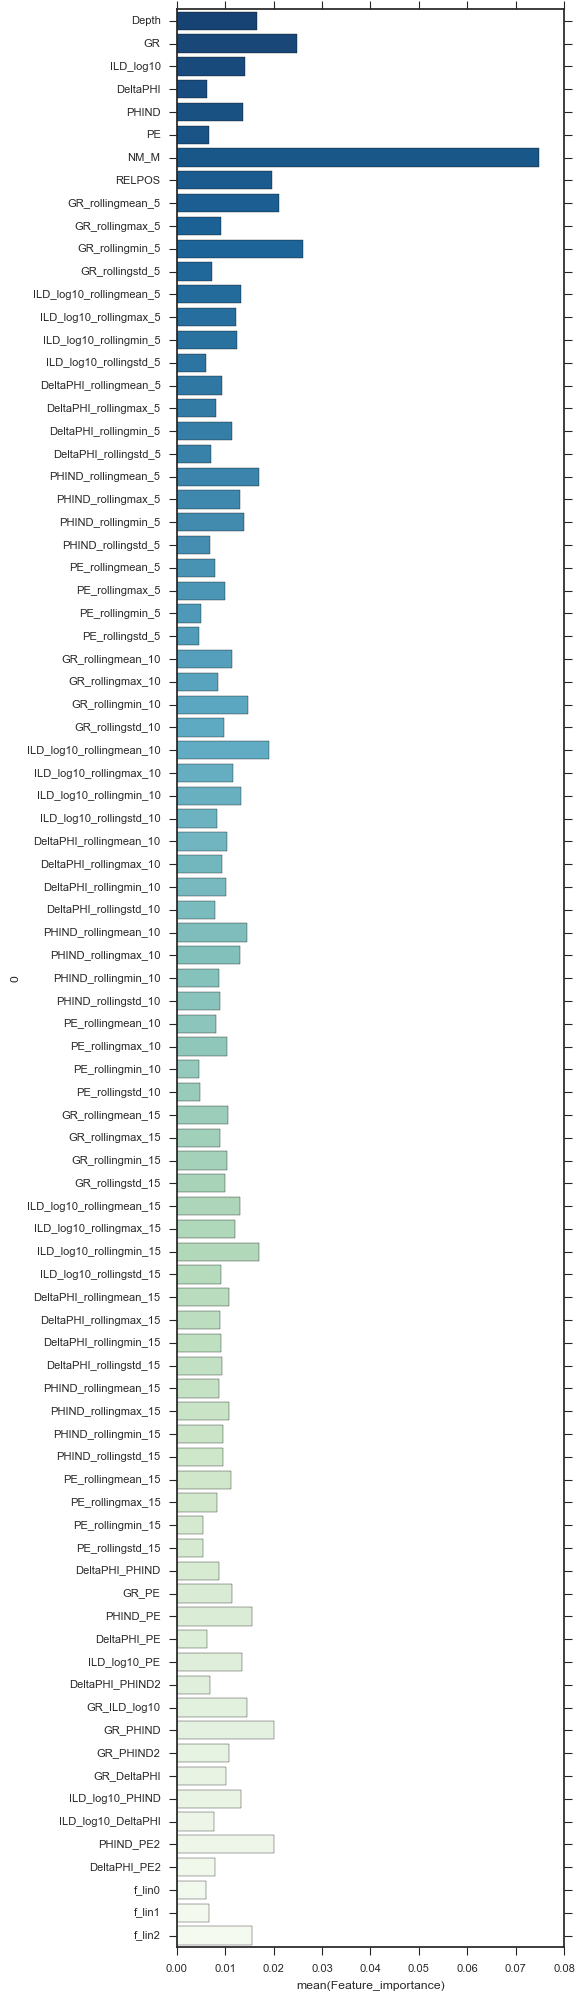

In [13]:
plt.rcParams['figure.figsize']=(5,25)
ax = sns.barplot(x="Feature_importance", y=0, data=df_F_L, palette="GnBu_r")

## Make confusion matrix


F1 score: 0.931393842059


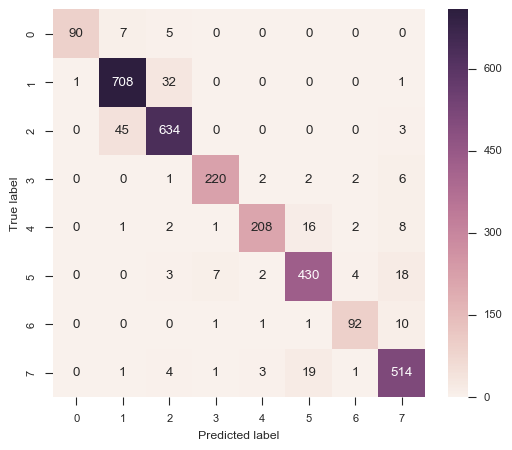

In [14]:
p_y=clf.predict(X)

def Plot_Confusion_Matrix(p_y, y):
    #### Print Score ####

    from sklearn.metrics import f1_score
    print ()
    print ("F1 score:", f1_score(y, p_y, average="weighted"))

    #### Make Confusion Matrix ####

    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(y, p_y)
    sns.heatmap(cnf_matrix, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.rcParams['figure.figsize']=(6,5)
Plot_Confusion_Matrix(p_y, y)

## Make prediction on test data

In [19]:
##### Load test data #####
df_test = pd.read_csv('validation_data_nofacies.csv')

df_out=Average_test(df_test)

#### Feature Engineering #####
Xts1 = prepare_X(df_out)

#Xts2 = drop_features(Xts1)
Xts2 = Xts1
Xts2 = Xts2.drop(["Formation", "Well Name"], 1)
print(Xts2.shape)

#### Scale X for test data ####
Xts3 = Scaler.transform(Xts2)

#### Predict y on the test data ###
p_y_ts=clf.predict(Xts3)

#### Merge predicted y with the test data ####
df_test_result=df_test
df_test_result["Predicted_y"]=p_y_ts

#### Save results to a csv file ####
df_test_result.to_csv("ADMC_Prediction_XGB_Submission_13")
df_test_result.head()

start (830, 70)
Wells used: ['STUART' 'CRAWFORD']
(830, 85)


,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,...,DeltaPHI_rollingstd_15,PHIND_rollingmean_15,PHIND_rollingmax_15,PHIND_rollingmin_15,PHIND_rollingstd_15,PE_rollingmean_15,PE_rollingmax_15,PE_rollingmin_15,PE_rollingstd_15,Predicted_y
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


## Visualise results

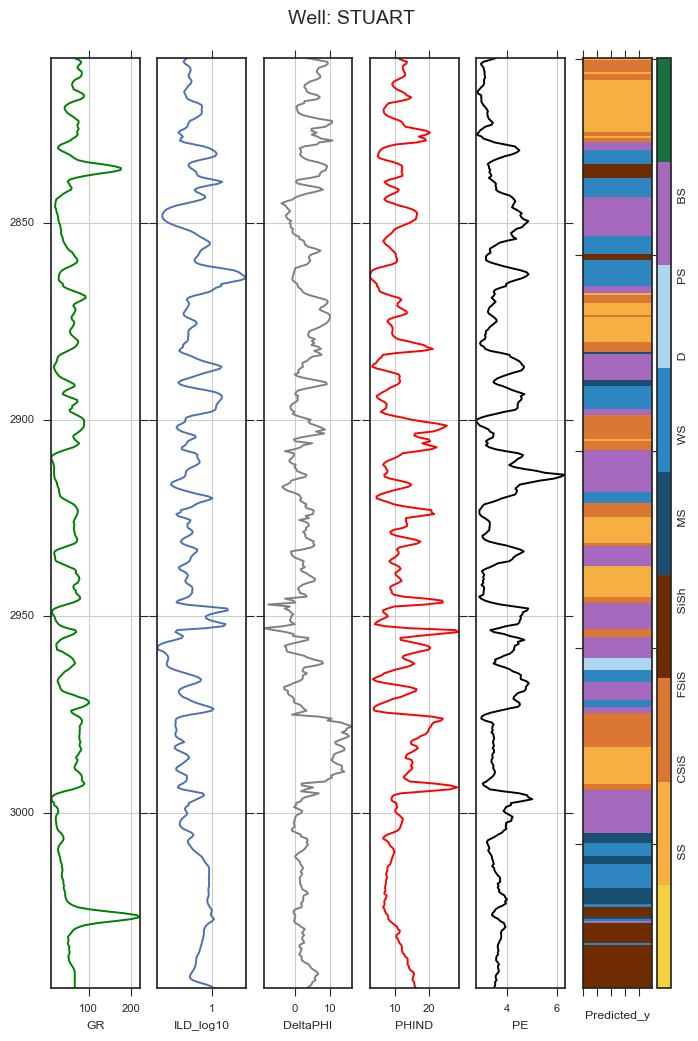

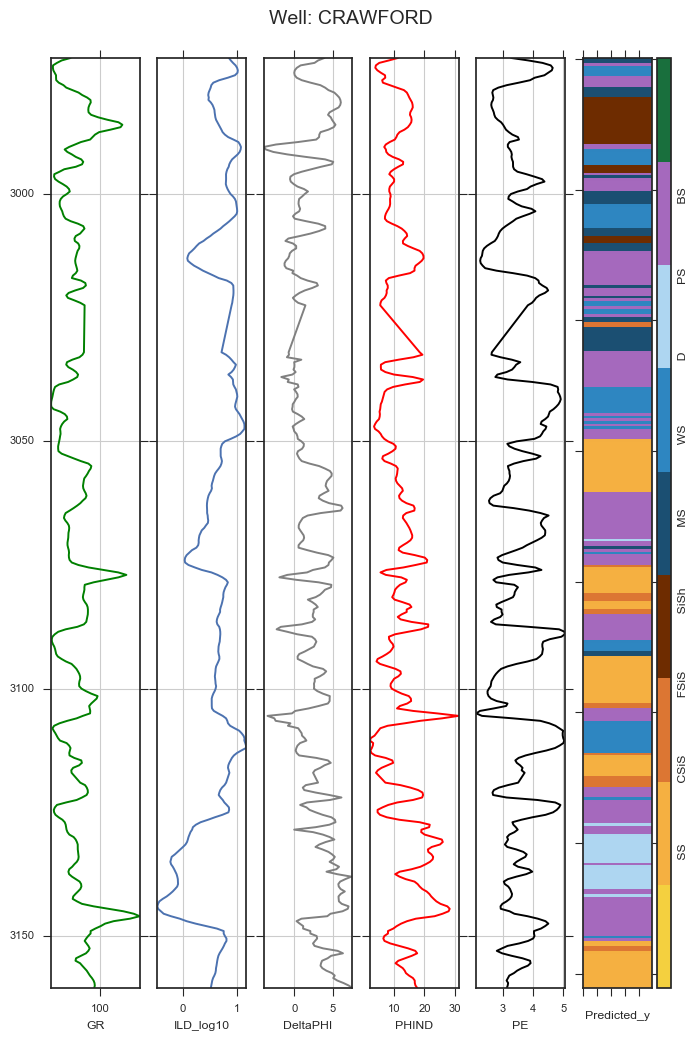

In [16]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

##### Plot result Wells ####
make_facies_log_plot(
    df_test_result[df_test_result['Well Name'] == 'STUART'],
    facies_colors)

make_facies_log_plot(
    df_test_result[df_test_result['Well Name'] == 'CRAWFORD'],
    facies_colors)

## Error Analysis
Consider what and why is creating errors. Previous investigations have used ROC curves and Precision vs. Recall plots. Additional testing has shown that slightly higher training scores do not always give higher test scores. To further optimize the results, visual comparisson of where the classifier is succesful and where there are errors. One outcome of this was the decision to remove CHURCHMAN BIBLE - This could be refined by only eliminating the specific depth intervals (3060-3070) where there is log interpolation which should not be inlcuded in training.

/Users/adammccarthy/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=3.72501392327, right=3.72501392327
  'left=%s, right=%s') % (left, right))


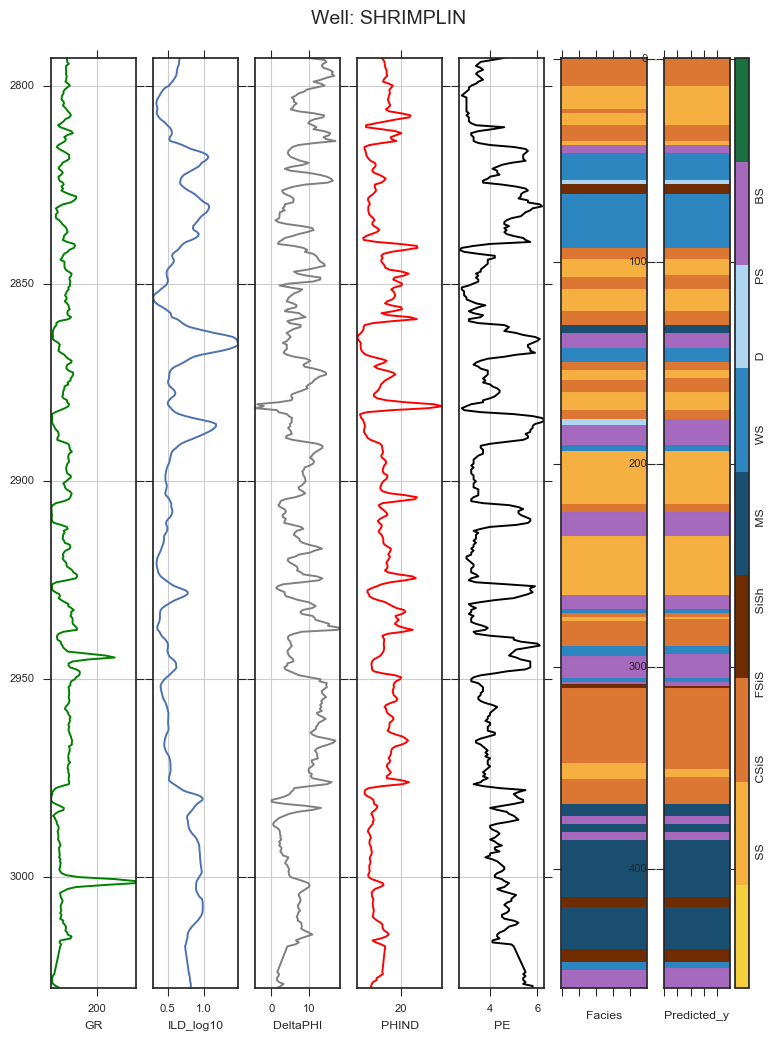

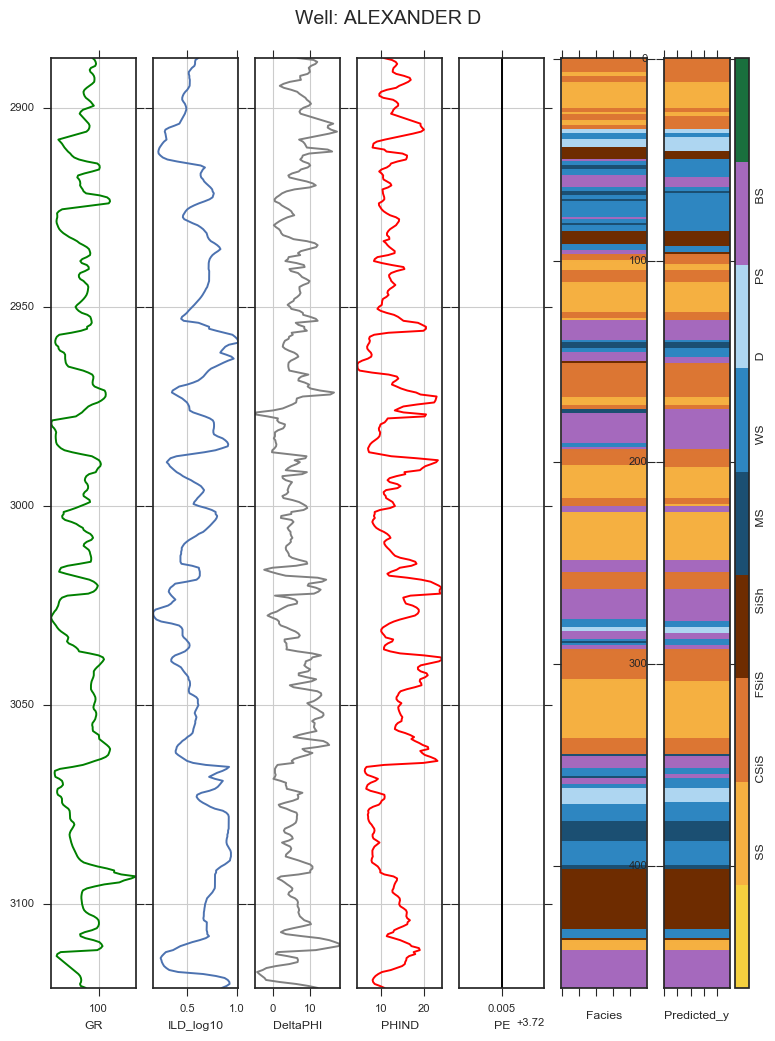

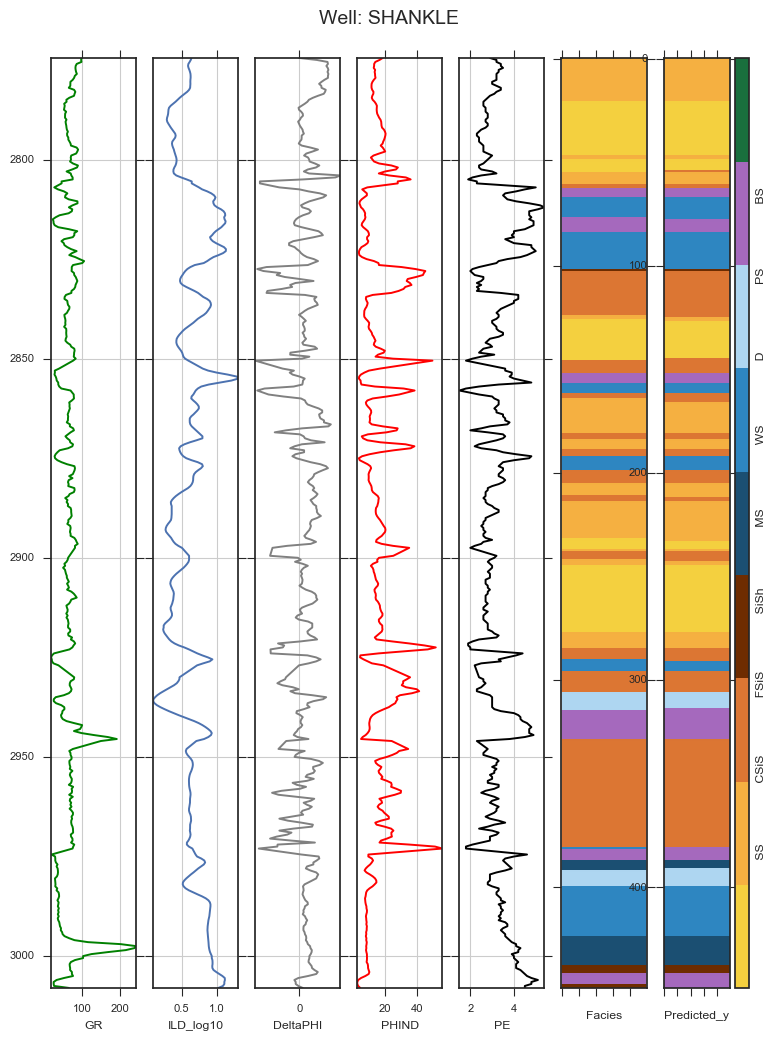

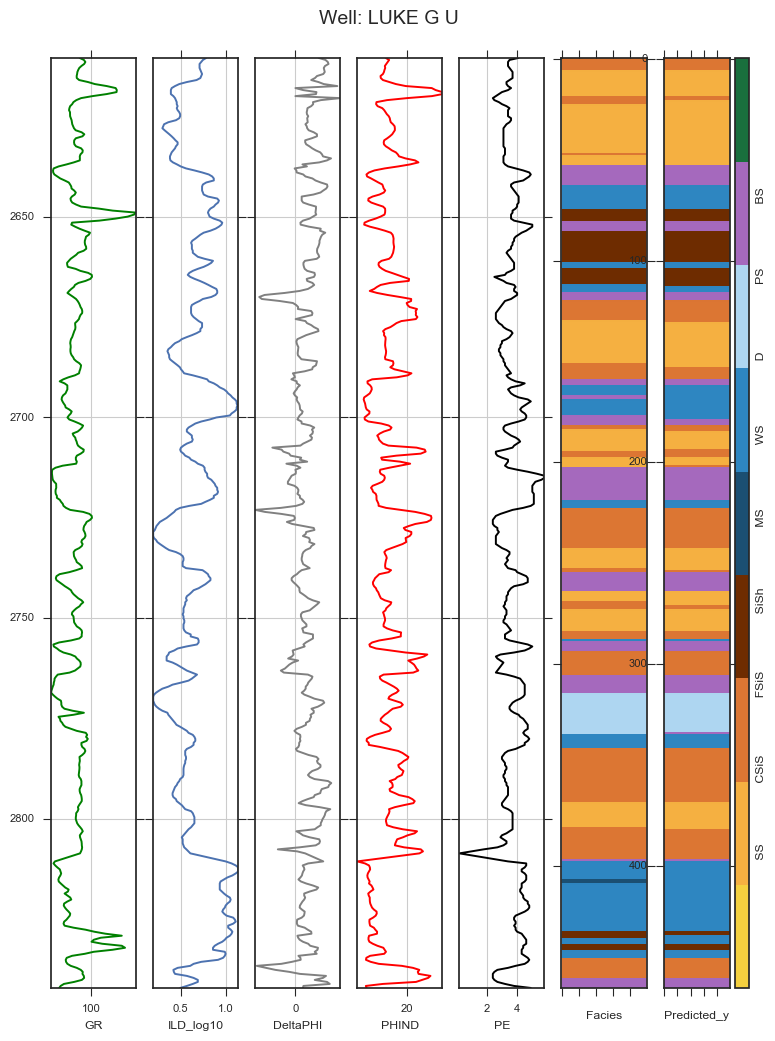

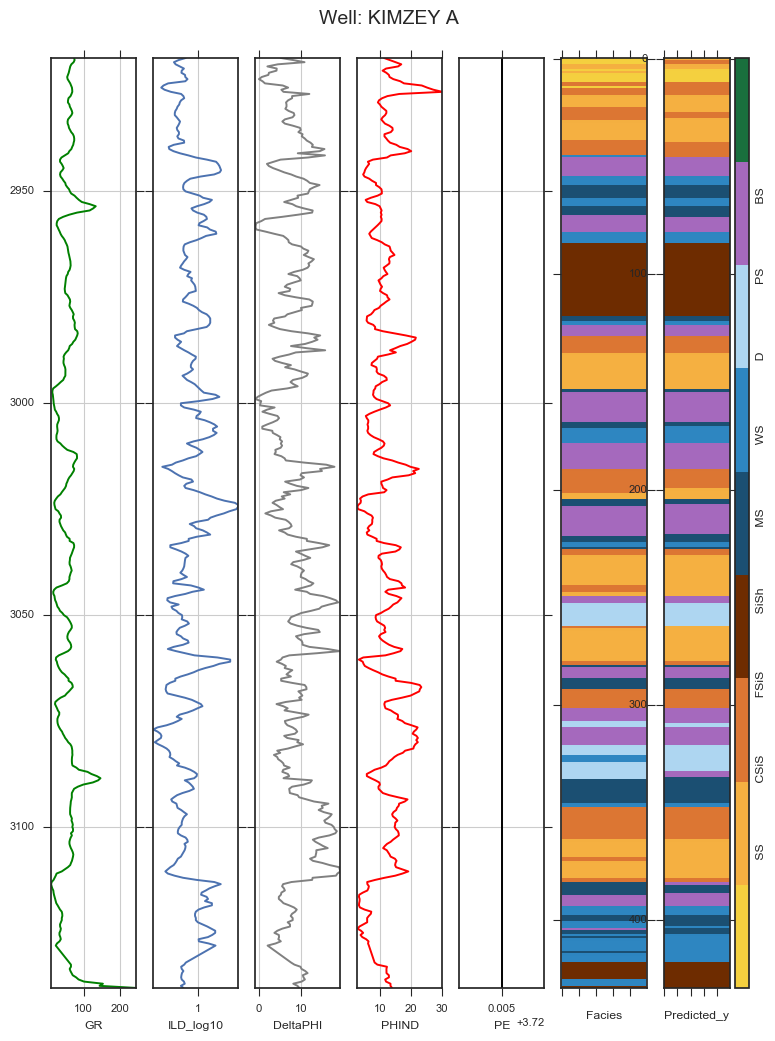

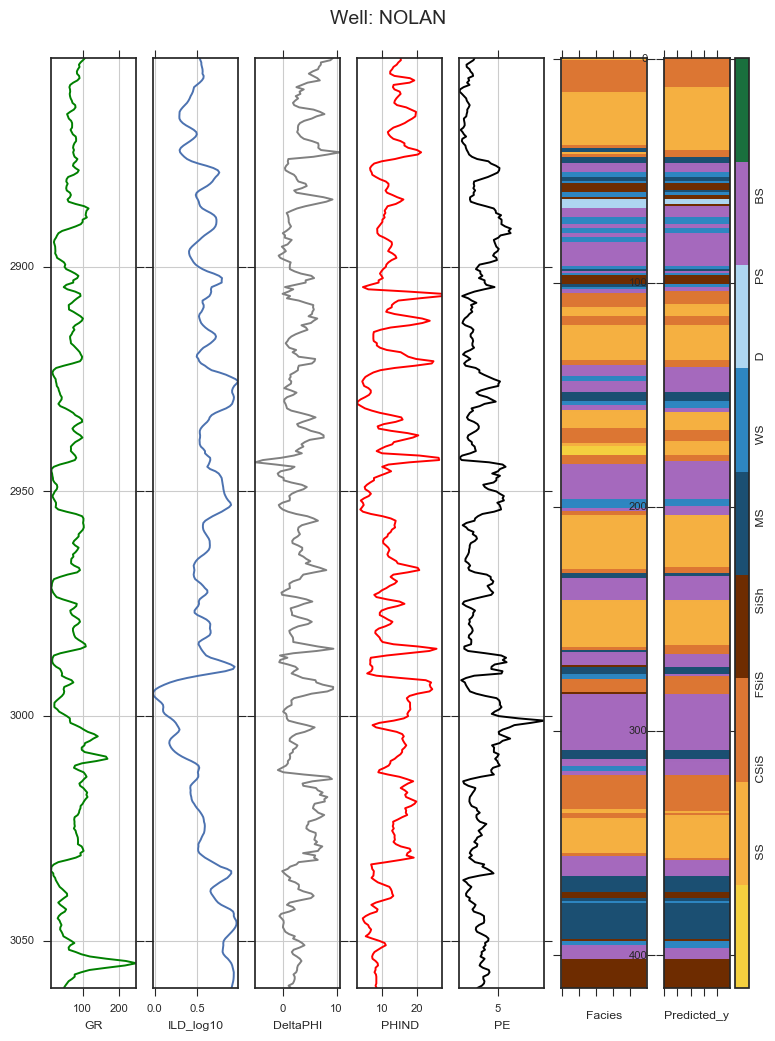

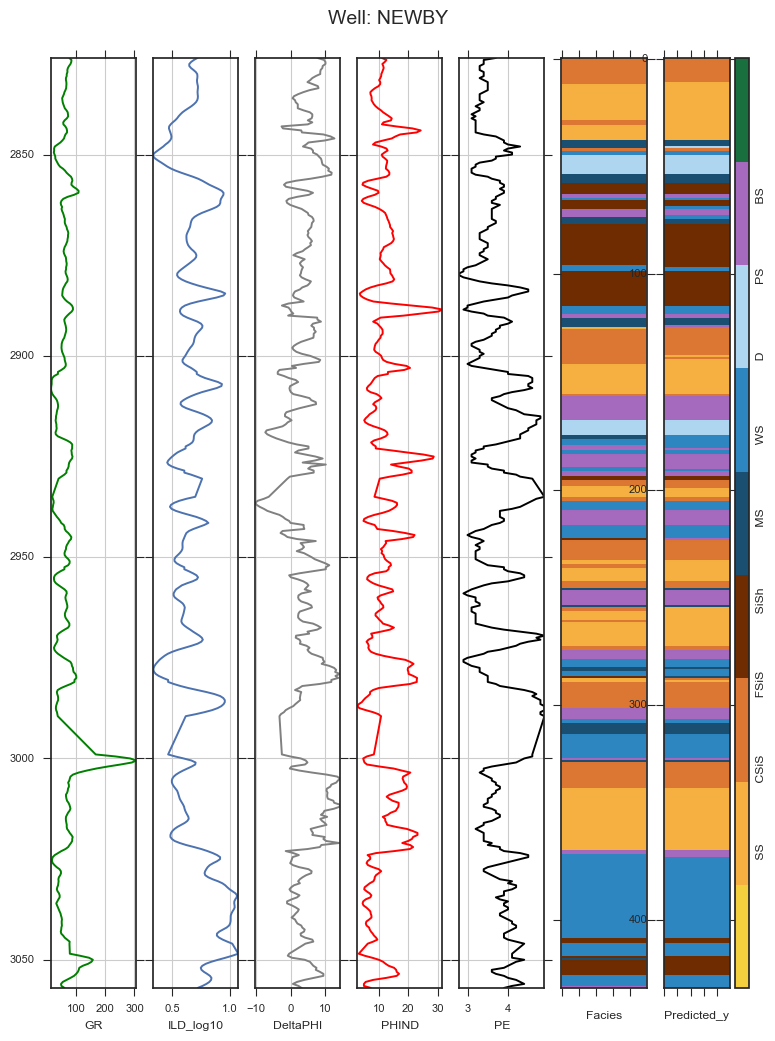

In [17]:
#### Merge predicted y with the test data ####
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

Facies_Plot = trX
grouped = Facies_Plot.groupby('Well Name')
Facies_Plot = Facies_Plot.rename(columns = {"Well Name":"Well_Name"}) # To be able to use the header in the .unique method
List = Facies_Plot.Well_Name.unique()

df_test_result=trX
df_test_result["Facies"]=Dataset["Facies"]
df_test_result["Predicted_y"]=p_y

for i in List:
    compare_facies_plot(
        df_test_result[df_test_result['Well Name'] == i],
        facies_colors)